# VGG with CAM
In this file, we implement the VGG + class activation mapping on the UC colonoscopy data. 

In [1]:
%matplotlib inline

In [2]:
import os
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [5]:
batch_size=64

In [6]:
gen = ImageDataGenerator()
train_gen = gen.flow_from_directory(path+'split_patients/train/', target_size=(256, 320), class_mode='categorical', shuffle=True,
                                    batch_size=batch_size)
test_gen = gen.flow_from_directory(path+'split_patients/validation/', target_size=(256, 320), class_mode='categorical', shuffle=False,
                                   batch_size=batch_size)

Found 5895 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.


## Show Some Rescaled Images

In [12]:
show_gen = ImageDataGenerator().flow_from_directory(path+'categorized/train/', target_size=(224, 224), class_mode='categorical', shuffle=True,
                                    batch_size=8)

Found 5939 images belonging to 4 classes.
Found 1494 images belonging to 4 classes.
Found 5939 images belonging to 4 classes.


In [13]:
show_batch, show_label = next(show_gen)

In [15]:
show_label

array([[ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.]], dtype=float32)

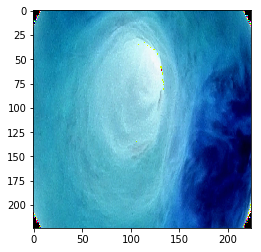

In [18]:
plt.imshow(show_batch[4])

## Fine Tuning

In [7]:
from keras.applications.inception_v3 import InceptionV3

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [9]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
checkpointer = ModelCheckpoint(filepath=model_path+'inception_v3_trn_top.h5', verbose=0, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1.e-8)

earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [12]:
4467+828+389+211

5895

In [13]:
class_weights = {0:(5895/4467.), 1:(5895./828), 2:(5895./389), 3:(5895./211)}

In [14]:
history = model.fit_generator(train_gen, steps_per_epoch=train_gen.n // batch_size, epochs=20, validation_data=test_gen, 
                    validation_steps=test_gen.n // batch_size, callbacks=[checkpointer, reduce_lr, earlystop], 
                             class_weight=class_weights)

Epoch 1/20
92/92 [==============================] - 387s 4s/step - loss: 4.3972 - acc: 0.6064 - val_loss: 1.1006 - val_acc: 0.5573
Epoch 2/20
92/92 [==============================] - 186s 2s/step - loss: 3.1245 - acc: 0.7551 - val_loss: 1.2681 - val_acc: 0.4277
Epoch 3/20
92/92 [==============================] - 185s 2s/step - loss: 2.6307 - acc: 0.8050 - val_loss: 1.2853 - val_acc: 0.4382
Epoch 4/20
92/92 [==============================] - 186s 2s/step - loss: 2.3818 - acc: 0.7978 - val_loss: 1.2212 - val_acc: 0.5085
Epoch 5/20
92/92 [==============================] - 186s 2s/step - loss: 2.2693 - acc: 0.8111 - val_loss: 1.2953 - val_acc: 0.4655
Epoch 6/20
92/92 [==============================] - 187s 2s/step - loss: 2.0143 - acc: 0.8277 - val_loss: 1.2347 - val_acc: 0.5169
Epoch 7/20
92/92 [==============================] - 187s 2s/step - loss: 1.8774 - acc: 0.8456 - val_loss: 1.2680 - val_acc: 0.5000
Epoch 8/20
92/92 [==============================] - 187s 2s/step - loss: 1.7523 - a

In [15]:
model.save_weights(model_path+'inceptionv3_trn_top_f.h5')

In [26]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [28]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [29]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
trn_gen = ImageDataGenerator(rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
tst_gen = ImageDataGenerator()
train_gen = trn_gen.flow_from_directory(path+'split_patients/train/', target_size=(256, 320), class_mode='categorical', shuffle=True,
                                    batch_size=batch_size)
test_gen = tst_gen.flow_from_directory(path+'split_patients/validation/', target_size=(256, 320), class_mode='categorical', shuffle=False,
                                   batch_size=batch_size)

Found 5895 images belonging to 4 classes.
Found 1538 images belonging to 4 classes.


In [30]:
checkpointer = ModelCheckpoint(filepath=model_path+'inception_v3_ft.h5', verbose=0, save_best_only=True, save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-8)

earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history = model.fit_generator(train_gen, steps_per_epoch=train_gen.n // batch_size, epochs=100, validation_data=test_gen, 
                    validation_steps=test_gen.n // batch_size, callbacks=[checkpointer, reduce_lr, earlystop], 
                             class_weight=class_weights)

Epoch 1/100
92/92 [==============================] - 354s 4s/step - loss: 2.6165 - acc: 0.7644 - val_loss: 1.3480 - val_acc: 0.4688
Epoch 2/100
92/92 [==============================] - 270s 3s/step - loss: 2.2517 - acc: 0.7975 - val_loss: 1.2930 - val_acc: 0.5215
Epoch 3/100
92/92 [==============================] - 269s 3s/step - loss: 1.9869 - acc: 0.8293 - val_loss: 1.3110 - val_acc: 0.5026
Epoch 4/100
92/92 [==============================] - 270s 3s/step - loss: 1.9538 - acc: 0.8244 - val_loss: 1.2310 - val_acc: 0.5378
Epoch 5/100
92/92 [==============================] - 271s 3s/step - loss: 1.7702 - acc: 0.8442 - val_loss: 1.2145 - val_acc: 0.5625
Epoch 6/100
92/92 [==============================] - 271s 3s/step - loss: 1.6889 - acc: 0.8426 - val_loss: 1.2151 - val_acc: 0.5664
Epoch 7/100
92/92 [==============================] - 270s 3s/step - loss: 1.7379 - acc: 0.8517 - val_loss: 1.1878 - val_acc: 0.5957
Epoch 8/100
92/92 [==============================] - 271s 3s/step - loss: 1.

## Model Evaluation

In [17]:
import pandas as pd
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [16]:
y_pred = model.predict_generator(test_gen)

In [22]:
y_pred_class = y_pred.argmax(axis=1)

In [20]:
y_true = np.load('output/y_true_sp.npy')
y_true_class = y_true.argmax(axis=1)

In [23]:
df = pd.DataFrame(data=np.column_stack((y_true_class, y_pred_class)), columns=('true', 'pred'))
pd.crosstab(index=df.true, columns=df.pred, margins=True)

pred,0,1,2,3,All
true,,,,,
0,726,170,94,18,1008
1,177,50,30,7,264
2,99,57,34,6,196
3,28,20,19,3,70
All,1030,297,177,34,1538


In [24]:
n_classes = y_pred.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

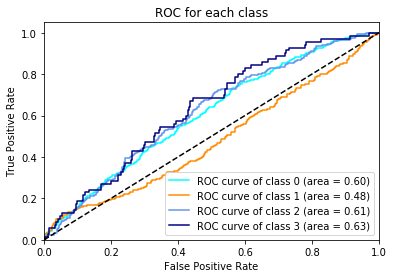

In [25]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for each class')
plt.legend(loc="lower right")